In [6]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation
import easygui as eg

In [8]:
# Define initial conditions of detector
""" 
Defaults source:
https://www.tribology-abc.com/calculators/properties_of_common_spring_materials.pdf <-- ASTM A228
https://optimumspring.com/technical_resources/materials/carbon_steels/music_wire_228_spring_wire.aspx <-- For mass density 
"""
params = eg.multenterbox("Enter wire params", 
                         fields=["Length [m]", "Mass Density [kg / m^3]", "Tensile strength [MPa]", "Youngs Modulus [kPa]", "Wire Diameter [mm]"],
                         values=[1, 7861.0929, 2751, 207, 0.004])
l = float(params[0]) # length of wire, meters
rho = float(params[1]) # mass density, kg/m^3
tensile_str = float(params[2]) * 10**6 # Tensile Strength of wire, Pa
young_mod = float(params[3]) * 10**3 # elastic modulus of wire, Pa
dia = float(params[4]) * 10**-3 # diameter of wire, meters
cs_area = np.pi * dia**2 / 4 # cross sectional area of wire, m^2

mu = rho * cs_area # linear mass density, kg/m
tension = 0.1 * tensile_str * cs_area # Tension on wire, N
v_press = np.sqrt(young_mod / rho) # wavespeed for longitudinal wave, m/s
v_shear = np.sqrt(tension / mu) # wavespeed for transverse waves, m/s

# Impact conditions of particle and track
G = 6.67430e-11 # gravitational constant
M = 3.2e-14 # mass of inciting particle, kg
v_p = 3.57e-7 # velocity of inciting particle, meters / second
""" Assuming 1 MeV energy M * v_p**2 = 1 MeV --> 0.2 * 0.8 = 1 for no reason 
    => M = 3.2e-14, v_p = 3.57e-7
"""

dz = .001 # mm step size for wire?
z0 = 1 # position of particle track and wire 'intersection', meters
b = .05 # shortest distance between wire and particle track, meters
theta = 0 # Angle between particle track and z (wire) axes, radians
phi = 0 # Angle between particle track and x axes, radians
zwire = np.arange(0 - z0, l - z0, dz) # define wire along z axes s.t. z0 is at z_string == 0
v_0 = 2 * G * M / (v_p * (b**2 + (zwire * np.sin(theta))**2)) # shared component of initial velocities

# Set up time erray for ivp solution
dt = .000001 # mus step size for time?
t0 = 0.0
tf = 0.01    # 10 ms total time
t_eval = np.arange(t0, tf, dt)


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
# Define needed functions
arr_dim = zwire.size
laplacian = sparse.diags([1, -2, 1], [-1, 0, 1], shape= (arr_dim, arr_dim)) / dz**2
disp_0 = np.zeros(arr_dim) # initial displacement as function of z

def couple_fun(t, u):
    """" 
    Function that returns first derivative in time for a coupled function of position and velocity 
    First arr_dim points return velocity: second arr_dim points of u
    Second arr_dim points return accelleration: v_p^2 * Laplacian.[first arr_dim points of u]
    """
    u[0] = 0 # fixed ends
    u[arr_dim - 1] = 0 #fixed ends
    du = np.zeros(2 * arr_dim) 
    # velocity is second half of coupled array (u)
    du[:arr_dim] = u[arr_dim:] 
    du[0] = 0 # fixed ends
    du[arr_dim - 1] = 0 # fixed ends
    # acceleration is wave eq on first half of coupled array (u)
    du[arr_dim:] = v_p**2 * laplacian.dot(u[:arr_dim]) 
    du[arr_dim] = 0 # fixed ends
    du[-1] = 0 # fixed end
    return du

def accell(t, sol):
    """
    Take solve_ivp coupled solution and a given time and return acceleration using 
    finite difference favouring symmetric difference (first and last frame use
    increasing and decreasing difference respectively)
    """
    d = 2
    if t == 0:
        less_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        less_dt = sol.y[arr_dim:, t - 1]
    if t == len(sol.t) - 1:
        more_dt = sol.y[arr_dim:, t]
        d = 1
    else:
        more_dt = sol.y[arr_dim:, t + 1]  
    return (more_dt - less_dt) / (d * dt)

KeyboardInterrupt: 

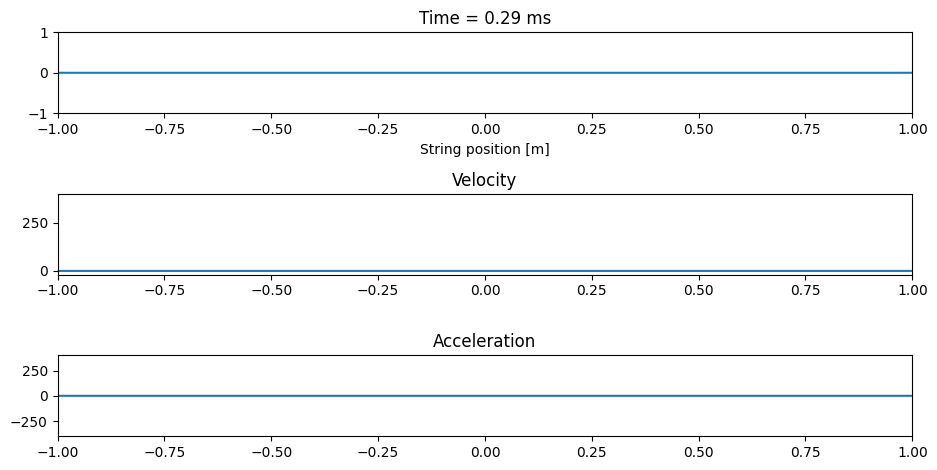

In [ ]:
# z axes wave 
v_z = - v_0 * zwire * np.sin(theta)**2 
# Initialize coupled array
u_0 = np.zeros(2*arr_dim)
u_0[:arr_dim] = disp_0
u_0[arr_dim:] = v_z

sol = solve_ivp(couple_fun, t_span= [t0, tf], y0= u_0, t_eval= t_eval, method="RK23")


fig1, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_xlabel('String position [m]')
title = ax1.set_title(' ')
line1, = ax1.plot([], [], label='Displacement')
line2, = ax2.plot([], [], label='Velocity')
line3, = ax3.plot([], [], label='Acceleration')
ax1.set_ylim(-G*M/v_p**2, G*M/v_p**2)
ax1.set_xlim(0 - z0, l - z0)
ax2.set_ylim(-G*M/(b * v_p**2), G*M/(b * v_p)**2)
ax2.set_xlim(0 - z0, l - z0)
ax3.set_ylim(-G*M/b**2, G*M/b**2)
ax3.set_xlim(0 - z0, l - z0)
ax1.set_title('Displacement')
ax2.set_title('Velocity')
ax3.set_title('Acceleration')

def init():
    line1.set_data([],[])
    line2.set_data([],[])
    line3.set_data([],[])
    return line1, line2, line3,

def animate(i):
    line1.set_data(zwire, sol.y[:arr_dim, i])
    line2.set_data(zwire, sol.y[arr_dim:, i])
    line3.set_data(zwire, accell(i, sol))
    title.set_text('Time = {:.2f} ms'.format(1000*sol.t[i]))
    return line1, line2, line3,

anim = animation.FuncAnimation(fig1, animate, init_func=init, frames=len(sol.t), interval=5, blit=True)
fig1.tight_layout()
fig1.set_figwidth(10)
writervideo = animation.FFMpegWriter(fps=60)
anim.save("{}.mp4".format(eg.enterbox("Enter animation filename", default="x axes anim")), writervideo)


In [ ]:
# x axes wave 
v_x = v_0 * zwire * np.sin(theta) * np.cos(theta)

In [ ]:
# y axes wave
v_y = v_0 * b